In [4]:
%load_ext autoreload
%autoreload 2

In [2]:
%env "WANDB_NOTEBOOK_NAME" 'train.ipynb'

env: "WANDB_NOTEBOOK_NAME"='train.ipynb'


In [1]:
import sys  
sys.path.insert(0, '../')

import torch

import umap
import umap.plot
from torchmetrics import Accuracy

import pytorch_lightning as pl

from learning_to_score.datasets import ClustersDataset, DataModule
from learning_to_score.model import Model
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

import seaborn as sns

import wandb

from pytorch_lightning.loggers import WandbLogger

pl.seed_everything(0)


Global seed set to 0


0

In [2]:
def train(
    group=None,
    input_dim=200,
    num_of_clusters=10,
    number_of_samples_in_cluster=1000,
    cluster_dim_mean=3,
    mean=0,
    variance=1,
    side_information_type='pure',
    triplet_loss_margin=1,
    alpha=1,
    beta=1,
    gamma=1,
    encoder_hidden_dims=[100, 50],
    latent_dim=20,
    epochs=10
):
    model = Model(
        input_dim=input_dim, 
        latent_dim=latent_dim, 
        encoder_hidden_dims=encoder_hidden_dims,
        triplet_loss_margin=triplet_loss_margin,
        number_of_clusters=num_of_clusters,
        alpha=alpha,
        beta=beta,
        gamma=gamma
    )
    
    wandb_logger = WandbLogger()

    run = wandb.init(
        group=group,
        config=model.hparams,
        save_code=True,
    )

    trainer = pl.Trainer(
        max_epochs=epochs, 
        track_grad_norm=2,
        logger=wandb_logger
    )
    
    wandb.watch(model)

    dataset = ClustersDataset(        
            num_of_clusters=num_of_clusters,
            number_of_samples_in_cluster=number_of_samples_in_cluster,
            side_information_type=side_information_type,
            cluster_dim_mean=cluster_dim_mean,
            mean=mean,
            variance=variance,
            dim=input_dim
        )
    dataset.setup()


    data_loader = DataModule(
        dataset
    )


    trainer.fit(model, data_loader, )

    run.finish()
    
    return trainer, model, data_loader
    

In [3]:
group = None
input_dim = 200
num_of_clusters = 10
number_of_samples_in_cluster = 1000
cluster_dim_mean = 3
mean = 0
variance = 2
side_information_type = "pure"
triplet_loss_margin = 1
alpha = 1
beta = 1
gamma = 1
encoder_hidden_dims = [100, 50]
latent_dim = 20
epochs = 100

trainer, model, data_loader = train(
    group=group,
    input_dim=input_dim,
    num_of_clusters=num_of_clusters,
    number_of_samples_in_cluster=number_of_samples_in_cluster,
    cluster_dim_mean=cluster_dim_mean,
    mean=mean,
    variance=variance,
    side_information_type=side_information_type,
    triplet_loss_margin=triplet_loss_margin,
    alpha=alpha,
    beta=beta,
    gamma=gamma,
    encoder_hidden_dims=encoder_hidden_dims,
    latent_dim=latent_dim,
    epochs=epochs,
)


In [7]:
trainer.logger = None

In [8]:
rs = trainer.predict(model, data_loader.test_dataloader())

/Users/yogev/.local/share/virtualenvs/LearningToScore-PFOi_1rt/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, predict dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Predicting: 313it [00:00, ?it/s]

In [9]:
labels = data_loader.test_dataloader().dataset.Y # from the side information
embeddings = torch.cat([r[0] for r in rs])
score_probs = torch.cat([r[1] for r in rs])
score = score_probs.argmax(axis=1)

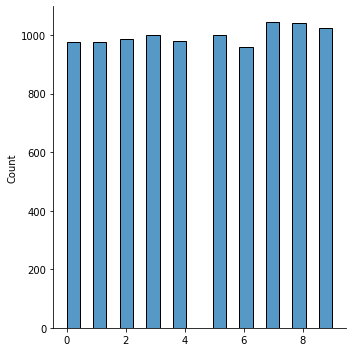

In [10]:
sns.displot(score)

In [11]:
accuracy = Accuracy()
accuracy(score, labels.squeeze().int())

tensor(0.0993)

In [13]:
labels.squeeze().int()

tensor([0, 0, 0,  ..., 9, 9, 9], dtype=torch.int32)

In [12]:
score

tensor([0, 0, 0,  ..., 3, 3, 3])

In [20]:
import networkx as nx
from networkx.algorithms import bipartite

import numpy as np

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, matthews_corrcoef


In [60]:
# def matchNmap(y,pred):
# Initialise the graph
wB_pred = nx.Graph()

# Add nodes with the node attribute "bipartite"
y_nodes = np.unique(y)
shift_pred_label = max(len(y_nodes),100)
pred_nodes = np.unique(pred) + shift_pred_label
wB_pred.add_nodes_from(y_nodes, bipartite=0)
wB_pred.add_nodes_from(pred_nodes, bipartite=1)

# Add edges with weight set to error prob
for prd_i in pred_nodes:
    pred_01 = (pred == (prd_i - shift_pred_label))
    for y_i in y_nodes:
        acc = sum((y == y_i) & pred_01)
        wB_pred.add_edge(prd_i, y_i, weight=1-acc/np.count_nonzero(y == y_i))

# Find minimum_weight_full_matching
matching = bipartite.matching.minimum_weight_full_matching(wB_pred, top_nodes=y_nodes, weight="weight")

# Remap pred and calc accuracy
new_pred = pred.copy()
for prd_i in pred_nodes:
    new_pred[pred == (prd_i-shift_pred_label)] = matching[prd_i]

#     return wB_pred, matching, new_pred

In [61]:
y == y_i

array([False, False, False, ...,  True,  True,  True])

In [62]:
prd_i- shift_pred_label

9

In [63]:
pred

array([0, 0, 0, ..., 3, 3, 3])

In [64]:
(pred == (prd_i - shift_pred_label))

array([False, False, False, ..., False, False, False])

In [65]:
y = labels.squeeze().int().numpy()
pred = score.numpy()

wB_pred, matching, new_pred = matchNmap(y, pred)
y_nodes, pred_nodes = bipartite.sets(wB_pred)
print(y_nodes, pred_nodes)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9} {100, 101, 102, 103, 104, 105, 106, 107, 108, 109}


In [66]:
print("\npred: \n",classification_report(y,pred))
print("\npred_DiffArgMax: \n",classification_report(y,new_pred))


pred: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.01      0.01      0.01      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.01      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.10      0.10      0.10     10000
weighted avg       0.10      0.10      0.10     10000


pred_DiffArgMax: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      1000
           1       0.94      0.98      0.96      1000
           2       0.96      0.94      0.95      

<AxesSubplot:>

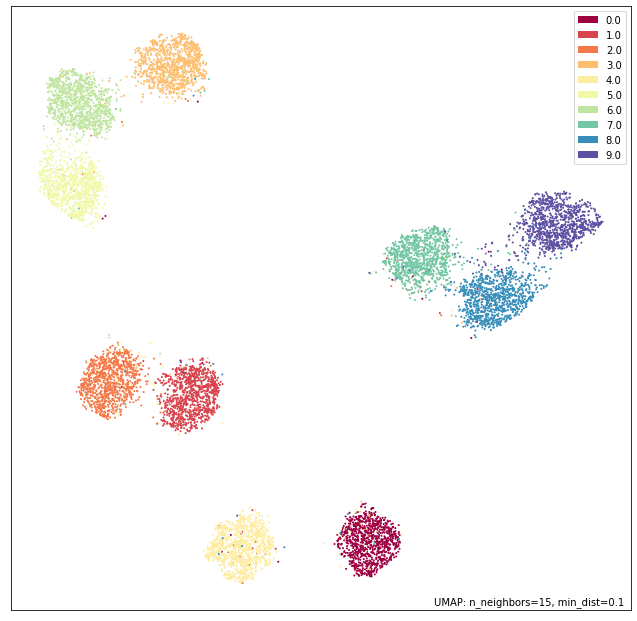

In [36]:
mapper = umap.UMAP().fit(embeddings)
umap.plot.points(mapper, torch.squeeze(labels))

<AxesSubplot:>

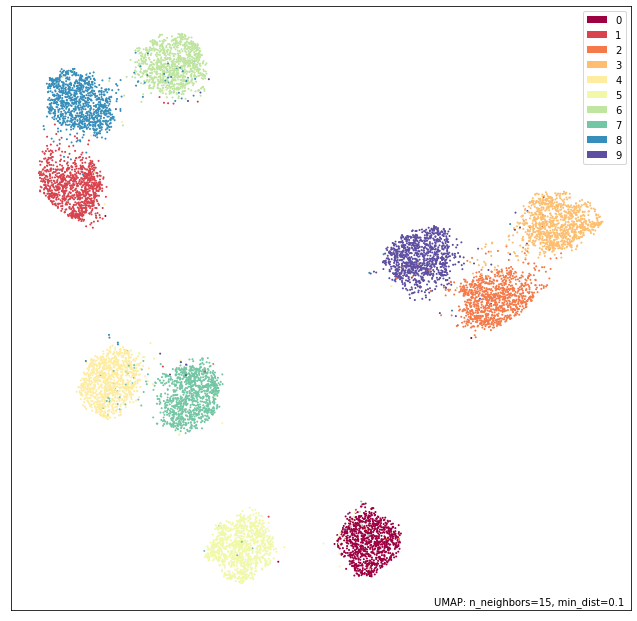

In [37]:
umap.plot.points(mapper, pred)

<AxesSubplot:>

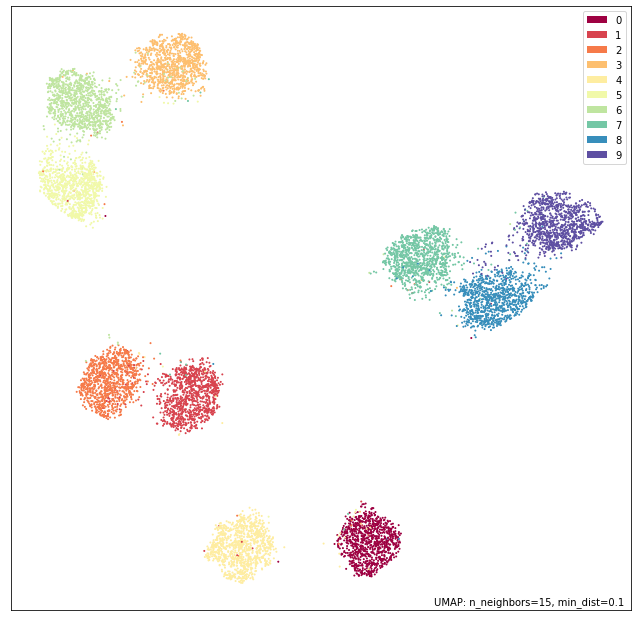

In [38]:
umap.plot.points(mapper, new_pred)

In [77]:
import seaborn as sns
import numpy as np

In [78]:
v = mapper.transform(embeddings)

In [79]:
v[:10].shape

(10, 1)

In [80]:
import matplotlib.pyplot as plt

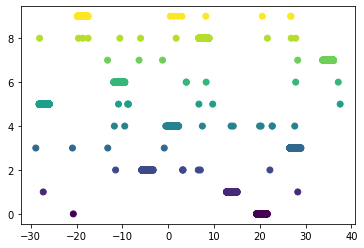

In [82]:
plt.scatter(v.T[0], labels.T[0], c=labels.T[0])

In [1]:
!pip install pytorch_lightning lightning-bolts
!pip install wandb umap-learn[plot]

  Using cached pytorch_lightning-1.7.1-py3-none-any.whl (701 kB)
     |████████████████████████████████| 316 kB 777 kB/s            
  Using cached tensorboard-2.10.0-py3-none-any.whl (5.9 MB)
  Using cached torchmetrics-0.9.3-py3-none-any.whl (419 kB)
  Using cached pyDeprecate-0.3.2-py3-none-any.whl (10 kB)
  Using cached aiohttp-3.8.1-cp39-cp39-macosx_10_9_x86_64.whl (574 kB)
  Using cached aiosignal-1.2.0-py3-none-any.whl (8.2 kB)
  Using cached multidict-6.0.2-cp39-cp39-macosx_10_9_x86_64.whl (28 kB)
  Using cached async_timeout-4.0.2-py3-none-any.whl (5.8 kB)
  Using cached yarl-1.8.1-cp39-cp39-macosx_10_9_x86_64.whl (61 kB)
  Using cached frozenlist-1.3.1-cp39-cp39-macosx_10_9_x86_64.whl (36 kB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.0
    Uninstalling tensorboard-2.9.0:
      Successfully uninstalled tensorboard-2.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This beha

In [2]:
import glob
import os
from typing import Any, Callable, Dict, List, Optional

import numpy as np
import pandas as pd
import psutil
import pytorch_lightning as pl
import torch
from PIL import Image, ImageFile
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import (CIFAR10, KMNIST, MNIST, SVHN, USPS,
                                  VisionDataset)

from torch.utils.data import DataLoader, Dataset



/Users/ykriger/.pyenv/versions/3.9.9/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


ModuleNotFoundError: No module named 'torchvision'